# Détection de fraud au payement

Ce jeu de données vous propose un nouveau problème de classification binaire : décider si un payement est une FRAUDE ou non.

### Objectifs 
* Récapituler les notions vues jusqu'à présent : classification binaire, validation, mesure de performance, hyper-optimisation.
* Découvrir une nouvelle famille d'algorithmes : les boosting trees
* Appréhender un problème de classification bianaire "déséquilibré"

Ce notebook va réutiliser les concepts déjà vu jusqu'à présent. Il contient moins de code et vous laisse plus libre dans l'implémentation. Réutilisez le code des notebooks précédents !

### Contexte 
Vous travaillez en tant que *Machine Learning Engineer* pour une **banque**. Les équipes de lutte contre la fraude souhaîte mettre en place un **algorithme pour arrêter la fraude** en temps réel : l'algorithme doit être capable de détecter si un virement est frauduleux ou non afin de le bloquer.

A partir d'un jeu de données qu'on vous fournit, il vous est demandé de mettre en place un tel algorithme. Dans ce jeu, un certain nombre de virements frauduleux a été préalablement détecté.

L'analyse des performances d'un tel algorithme permettra de décider de la mise en place ou non d'un tel moteur de détection en temps réel, qui se basera sur votre algorithme.

Par ailleurs, un de vos collègues a mis en place 2 modèles de détection auxquels il va falloir vous comparer.


(faire le coup de la fonction qui renvoie 0, ou 1 aléatoirement !! Montrer que courbe ROC pas fou, et montrer d'autres mesures.)

## Modèle de comparaison

Les 2 modèles suivants sont des modèles "naïf" de détection de fraude. Serez-vous capable d'obtenir un meilleur modèle ?

Ces modèles s'utilisent de la même manière que les modèles vus précédemment : ils ont une méthode _fit_ pour l'entraînement et _predict_ ou _predict_proba_ pour la prédiction.


In [1]:
import numpy as np

In [2]:
# Model 1

class RandomFraudDetector:
    def __init__(self, p):
        self.p = p
        assert 0 <= p <= 1

    def fit(self, X, y):
        return self

    def predict(self, X):
        scores = self.predict_proba(X)
        return scores > 0.5 
    
    def predict_proba(self, X):
        scores =  self.p * 2 * np.random.rand(X.shape[0])
        scores[scores<0] = 0
        scores[scores>1] = 1
        return scores

randomFraudDetector = RandomFraudDetector(0.1)

In [3]:
# Model 2

class NaiveFraudDetector:
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.zeros((X.shape[0],)) 
    
    def predict_proba(self, X):
        return np.zeros((X.shape[0],))

naiveFraudDetector = NaiveFraudDetector()

# Lecture du dataset

Dans cette première section :
* Lecture du dataset
* Quelle est la cible ? Quelles sont les features exploitables ?
* Effectuer quelques visualisation
  * Quelle est la durée pendant laquelle les données ont été collectées ?
  172788.000000
  * Est-ce que les fraudes sont réparties dans le temps ?
  * Quel est le montant des transactions en général et des fraudes en particulier ?

Les colonnes du jeu de données sont : 
* _Class_ : est-ce que c'est une fraude ?
* _Time_ : moment de la transaction
* _Amount_ : montant de la transaction
* _V1_ à _V28_ : des features numériques anonymisées

In [4]:
import pandas as pd
dataset = pd.read_csv("./datasets/CreditCardFraud_short.csv")
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142645,163942.0,-1.019203,0.481492,2.274583,4.241325,1.574835,1.261159,-0.642177,0.504488,-2.209828,...,0.310800,0.633903,-0.249594,0.219320,0.270599,0.546483,0.083095,0.110002,0.76,0
142646,63899.0,-0.370668,0.988509,2.608039,2.110778,-0.256008,0.272036,0.118741,0.193841,-0.587576,...,-0.002159,0.146565,-0.123053,0.406696,-0.110622,-0.087303,0.074957,0.044112,0.00,0
142647,41231.0,-0.428687,0.948979,1.287959,-0.028794,0.032788,-0.698476,0.539625,0.126356,-0.518914,...,-0.214565,-0.653256,0.008115,0.252761,-0.215620,0.057347,0.231959,0.087622,9.99,0
142648,35059.0,-1.075405,1.338826,0.117071,-0.204691,-0.524877,-1.261053,0.435116,0.439694,-1.098636,...,-0.151833,-0.721981,0.147504,0.459192,-0.685286,0.718542,-0.275357,-0.044909,53.80,0


<AxesSubplot:xlabel='Class'>

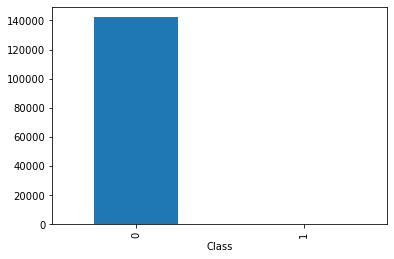

In [63]:
dataset.groupby("Class")\
    .size()\
    .plot(kind="bar")

<AxesSubplot:>

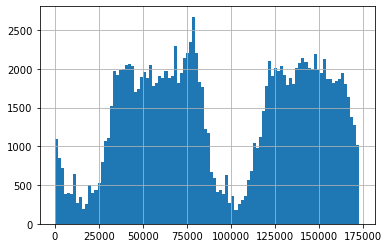

In [8]:
dataset.Time.hist(bins=100)

<AxesSubplot:>

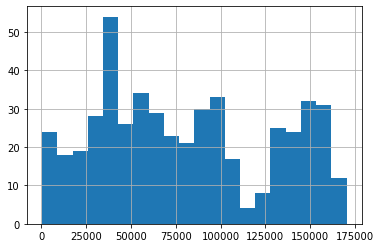

In [14]:
dataset.Time[dataset.Class==1].hist(bins=20)

In [12]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,...,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000
mean,94677.929253,-0.007050,0.004056,-0.011304,0.009424,-0.002958,0.000627,-0.012453,-0.000981,-0.004972,...,0.003174,-0.000610,-0.002560,-0.000686,0.000436,0.000115,0.000825,0.000037,88.745935,0.003449
std,47494.482627,1.974970,1.659505,1.567832,1.433025,1.408642,1.339431,1.301774,1.238532,1.106258,...,0.762461,0.728189,0.640051,0.606121,0.522565,0.481416,0.410964,0.322757,255.308044,0.058627
min,0.000000,-41.928738,-63.344698,-48.325589,-5.683171,-113.743307,-23.496714,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-22.565679,-15.430084,0.000000,0.000000
25%,54059.250000,-0.924680,-0.601086,-0.896247,-0.848524,-0.693995,-0.769489,-0.558662,-0.208788,-0.646591,...,-0.228648,-0.541367,-0.161351,-0.353271,-0.316094,-0.327194,-0.070704,-0.052765,5.500000,0.000000
50%,84561.500000,0.016842,0.063652,0.178209,-0.018107,-0.053053,-0.271855,0.036016,0.022832,-0.053196,...,-0.029263,0.006065,-0.010805,0.040610,0.017243,-0.052377,0.001628,0.011278,21.990000,0.000000
75%,139280.000000,1.314683,0.805674,1.025394,0.749235,0.615261,0.400963,0.566909,0.329012,0.596569,...,0.187450,0.530198,0.147275,0.437888,0.351413,0.241244,0.092084,0.078428,77.597500,0.000000
max,172788.000000,2.454930,22.057729,9.382558,16.715537,34.099309,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.415636,31.612198,22.620072,25691.160000,1.000000


In [13]:
dataset["Class"].value_counts()

0    142158
1       492
Name: Class, dtype: int64

## Premiers modèles

Dans cette partie, il vous est demandé :
* d'effectuer un premier modèle à partir d'un randomForest. Quelle est la meilleure précision que vous pouvez atteindre ?
* comparer ce score avec le score des modèles naïfs.

Qu'en pensez-vous ?



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

X = dataset.drop(["Class"], axis=1).copy()
y = dataset["Class"]
X.shape, y.shape



((142650, 30), (142650,))

In [31]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(f"Shape of 'X_train' is: {X_train.shape}")
print(f"Shape of 'X_test' is: {X_test.shape}")
print(f"Shape of 'y_train' is: {y_train.shape}")
print(f"Shape of 'y_test' is: {y_test.shape}")

Shape of 'X_train' is: (99855, 30)
Shape of 'X_test' is: (42795, 30)
Shape of 'y_train' is: (99855,)
Shape of 'y_test' is: (42795,)


In [32]:
class_rate_train = y_train.mean()
class_rate_test = y_test.mean()

print(f"Churn Rate in trainset is: {class_rate_train:.3f}")
print(f"Churn Rate in testset is: {class_rate_test:.3f}")

Churn Rate in trainset is: 0.004
Churn Rate in testset is: 0.003


In [50]:
def compute_randomForest_auc(max_depths):
    """
    This function compute the ROC AUC of a RandomForest algorithm
    Input: max_depths : paramter to pass to the algorithm
    Output
    * roc auc on traintest
    * roc auc on testset
    """
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(n_estimators=1,max_depth=max_depths,min_samples_split=3)
    model.fit(X_train, y_train)
    
    y_train_pred_proba = model.predict_proba(X_train)[:,1]
    y_test_pred_proba = model.predict_proba(X_test)[:,1]
    
    auc = roc_auc_score(y_train.values, y_train_pred_proba)
    auc2 = roc_auc_score(y_test.values, y_test_pred_proba)
    
    return auc, auc2

compute_randomForest_auc(5)

(0.9011573827572767, 0.8706669029223542)

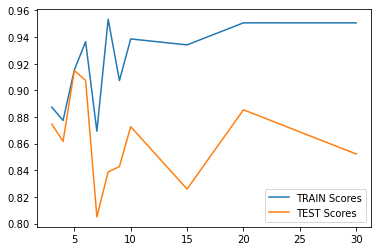

In [51]:
xx = list(range(3,11)) +[15, 20, 30]
train_scores, test_scores = zip(*[compute_randomForest_auc(n) for n in xx])

plt.plot(xx, train_scores, label="TRAIN Scores")
plt.plot(xx, test_scores, label="TEST Scores")
plt.legend()

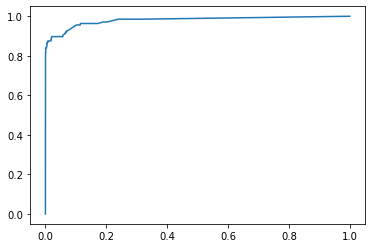

In [52]:
# Here we write a function to help implement K-fold validation
def compute_RF_performance(X_train, y_train, X_test, y_test, **params):
    """
    This function computes performance of RF for given Train/Test set
    X_train/y_train are features and target for trainset
    X_test/y_test are features and target for testset
    params is a set of parameters to pass to the algorithm
    It should plot the ROC Curve on test set
    """
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thr = roc_curve(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_pred)
    plt.plot(fpr, tpr, label=f"ROC (auc={auc:.3f})")
    
compute_RF_performance(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=4)

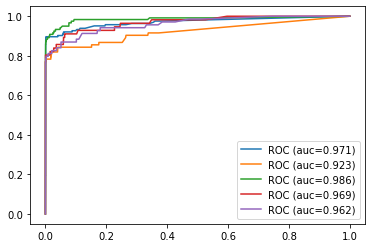

In [53]:
# Here do the actual K-Fold
# Hint : check out doc for dataframe method iloc
from sklearn.model_selection import KFold

cv = KFold(n_splits=5) 
for train, test in cv.split(X):
    compute_RF_performance(X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test], n_estimators=100, max_depth=4)
    plt.legend()

<AxesSubplot:>

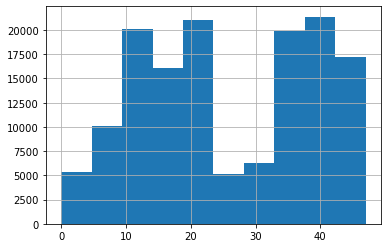

In [40]:
dataset["Hour"] = dataset["Time"] // 3600
dataset.Hour.hist()

In [41]:
AmountByHour = pd.DataFrame(dataset.groupby("Hour")['Amount'].sum()).reset_index()
AmountByHour.columns = ["Hour","AmountByHour"]
AmountByHour

,Hour,AmountByHour
0,0.0,123075.65
1,1.0,71944.56
2,2.0,57377.91
3,3.0,40167.61
4,4.0,38382.78
5,5.0,44534.37
6,6.0,64713.54
7,7.0,147418.51
8,8.0,247760.38
9,9.0,383119.40


In [42]:
dataset = dataset.merge(AmountByHour, on="Hour")
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,AmountByHour
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,0.0,123075.65
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,0.0,123075.65
2,654.0,1.239994,0.687840,-0.231326,1.309509,0.050955,-1.191854,0.314967,-0.259432,-0.121488,...,-0.122337,0.284169,0.700277,-0.328469,0.033619,0.051824,1.00,0,0.0,123075.65
3,1188.0,-0.919453,0.582893,2.567501,0.080959,-0.736130,0.163369,0.016658,-0.900189,0.322579,...,-0.093434,0.718009,0.007738,1.329511,-0.208140,-0.138418,30.30,0,0.0,123075.65
4,1214.0,1.317657,0.411637,-0.019163,0.487618,0.127257,-0.576338,0.140443,-0.211726,-0.069716,...,0.013140,-0.479521,0.363736,0.143601,-0.017001,0.024302,0.89,0,0.0,123075.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142645,105937.0,2.053574,-0.469642,-1.118031,0.793019,-0.137746,-0.236218,-0.380824,-0.270417,0.747876,...,0.008996,0.532923,0.283599,-0.379515,0.004878,-0.040874,48.00,0,29.0,37266.55
142646,107825.0,-1.044093,0.769217,1.687345,-0.875859,-0.318126,0.397706,-0.275608,0.459081,3.049664,...,-0.217673,-0.699971,-0.064328,-0.696674,0.271632,-0.009033,9.02,0,29.0,37266.55
142647,107539.0,0.019430,0.665030,1.756383,0.139589,-0.449154,-0.176595,-0.303494,-0.879180,1.733656,...,-0.264425,-0.140570,1.340896,-0.577720,0.105448,0.151143,11.27,0,29.0,37266.55
142648,106776.0,-0.533121,1.404094,-0.786295,-0.283826,0.195658,-0.272736,0.695768,-0.682214,1.125001,...,0.144411,0.568973,-0.732017,-0.271633,0.430537,0.243431,99.99,0,29.0,37266.55


# Modèle Boosting Tree

On a utilisé précédemment le random Forest. L'algorithme se base sur les arbres de décisions. La stratégie de l'algorithme consiste à utiliser un grand nombre d'estimateurs (les arbres) qui ont tendance à overfitté individuellement, mais collectivement le comportement sera beaucoup moins variables (des tirages aléatoires permettant d'avoir des arbres toujours légèrement différents.)


Les Boosting Tree partent sur une autre stratégie : l'idée est d'utiliser une série d'arbre, construit successivement, dont chacun va tenter de réduire l'erreur d'estimation des précédents arbres.

En comparaison :
* Random Forest : minimisation de la variance en construisant des arbres aléatoires et indépendant
* Boosting Tree : minimisation du biais en construisant successivement des arbres liés entre eux

Il existe plusieurs implémentations avec des différences.
Dans le package scikit-learn : Gradient Boosting Tree & AdaBoost.

Exceptionnellement nous allons utiliser un algorithme d'un autre package, mais qui est très populaire : **xgboost**

Voir la documentation : https://xgboost.readthedocs.io/en/latest/get_started.html

La ligne suivante permet de vérifier que le package est bien installé.


In [57]:
import xgboost as xgb

Dans la suite, nous vous proposer de créer un modèle xgboost et de l'évaluer. Est-ce que le résultat est meilleur ou moins bon ?

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(f"Shape of 'X_train' is: {X_train.shape}")
print(f"Shape of 'X_test' is: {X_test.shape}")
print(f"Shape of 'y_train' is: {y_train.shape}")
print(f"Shape of 'y_test' is: {y_test.shape}")

Shape of 'X_train' is: (99855, 31)
Shape of 'X_test' is: (42795, 31)
Shape of 'y_train' is: (99855,)
Shape of 'y_test' is: (42795,)


In [59]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [68]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)
preds

[16:51:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.04195299, 0.04195299, 0.04195299, ..., 0.04195299, 0.04195299,
       0.04195299], dtype=float32)

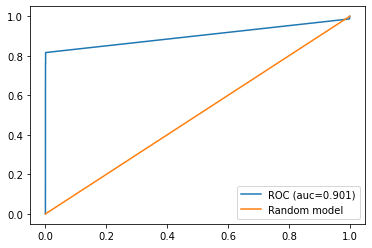

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thr = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, label=f"ROC (auc={auc:.3f})")

plt.plot([0,1], [0,1], label="Random model")
plt.legend()

# Rééquilibrage des classes


Dans le cas comme ici avec un grand déséquilibre entre les classes, une technique courante et de les rééquilibrer. Il existe plusieurs possibilités, par exemple : 
* Supprimer des observations de la classe trop représentée pour avoir une partié correcte
* Générer des éléments de la classe sous-représentés à partir des éléments existants

Pouvez-vous essayer l'une ou l'autre de ces approches ?


In [ ]:
# TODO